In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [157]:
data=pd.read_csv("assembly-elections-data-at-candidate-level.csv")

In [158]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122559 entries, 0 to 122558
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     122559 non-null  int64  
 1   year                   122559 non-null  int64  
 2   month                  122559 non-null  int64  
 3   state_name             122559 non-null  object 
 4   state_code             122559 non-null  int64  
 5   assembly_no            122559 non-null  float64
 6   ac_name                122559 non-null  object 
 7   ac_type                122559 non-null  object 
 8   candidate_name         122559 non-null  object 
 9   sex                    114083 non-null  object 
 10  age                    100988 non-null  float64
 11  candidate_type         121418 non-null  object 
 12  party                  122559 non-null  object 
 13  position               122559 non-null  float64
 14  ac_total_candidates    122559 non-nu

In [159]:
data.isnull().sum()

id                           0
year                         0
month                        0
state_name                   0
state_code                   0
assembly_no                  0
ac_name                      0
ac_type                      0
candidate_name               0
sex                       8476
age                      21571
candidate_type            1141
party                        0
position                     0
ac_total_candidates          0
total_electors             254
total_votes                  0
total_valid_votes            0
vote_share_percentage       13
margin                       0
margin_percentage           13
turnout_percentage         254
poll_no                      0
delimit_id                   0
dtype: int64

In [160]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
ref_data = pd.read_csv("Gender_Data.csv") 
ref_data.columns = ['first_name', 'sex']  
ref_data['first_name'] = ref_data['first_name'].astype(str).str.upper().str.strip()
ref_data['sex'] = ref_data['sex'].astype(int)
missing = pd.read_csv("names_missing_sex.csv")  
missing.columns = ['first_name']
missing['first_name'] = missing['first_name'].astype(str).str.upper().str.strip()
invalid_keywords = ['NOTA', 'NONE']
missing_valid = missing[
    ~missing['first_name'].isin(invalid_keywords) &
    ~missing['first_name'].str.contains(r'\.') &
    (missing['first_name'].str.len() >= 3)
].reset_index(drop=True)
model = Pipeline([
    ('vectorizer', CountVectorizer(analyzer='char', ngram_range=(2, 4))),
    ('classifier', MultinomialNB())
])
model.fit(ref_clean['first_name'], ref_clean['sex'])
missing_valid['sex_predicted'] = model.predict(missing_valid['first_name'])
missing_valid['sex_predicted'] = missing_valid['sex_predicted'].map({0: 'M', 1: 'F'})
excluded = missing[
    ~missing['first_name'].isin(missing_valid['first_name'])
].copy()
excluded['sex_predicted'] = 'UNKNOWN'
final_result = pd.concat([missing_valid, excluded]).reset_index(drop=True)
final_result.to_csv("missing_sex_filled.csv", index=False)
print("✅ All done! Saved as 'missing_sex_filled.csv'")


✅ All done! Saved as 'missing_sex_filled.csv'


In [161]:
predicted_sex = pd.read_csv("missing_sex_filled.csv")
predicted_sex.columns = ['candidate_name', 'sex_predicted']
data['candidate_name'] = data['candidate_name'].astype(str).str.upper().str.strip()
predicted_sex['candidate_name'] = predicted_sex['candidate_name'].astype(str).str.upper().str.strip()
data['sex'] = data.apply(
    lambda row: predicted_sex.loc[predicted_sex['candidate_name'] == row['candidate_name'], 'sex_predicted'].values[0]
    if pd.isna(row['sex']) and row['candidate_name'] in predicted_sex['candidate_name'].values
    else row['sex'],
    axis=1
)
print(data['sex'].isna().sum(), "missing values left in 'sex'")


1465 missing values left in 'sex'


In [162]:
data['candidate_name'] = data['candidate_name'].astype(str).str.upper().str.strip()
data.loc[(data['sex'].isna()) & (data['candidate_name'] != 'NOTA'), 'sex'] = 'UNKNOWN'
print("Remaining missing values in 'sex':", data['sex'].isna().sum())


Remaining missing values in 'sex': 0


In [163]:
print(data['sex'].value_counts())


sex
MALE       104577
FEMALE       9469
UNKNOWN      8371
M              83
THIRD          37
F              22
Name: count, dtype: int64


In [164]:
data['sex'] = data['sex'].str.upper().str.strip()
sex_map = {
    'M': 'MALE',
    'F': 'FEMALE'
}
data['sex'] = data['sex'].replace(sex_map)
print(data['sex'].value_counts())


sex
MALE       104660
FEMALE       9491
UNKNOWN      8371
THIRD          37
Name: count, dtype: int64


In [165]:
nota_rows = data[data['candidate_name'].str.upper().str.strip() == 'NOTA']
print(nota_rows[['candidate_name', 'sex']].value_counts())


candidate_name  sex    
NOTA            UNKNOWN    6691
                FEMALE        3
Name: count, dtype: int64


In [166]:
data['candidate_name'] = data['candidate_name'].astype(str).str.upper().str.strip()
data.loc[data['candidate_name'] == 'NOTA', 'sex'] = 'NOTA'
print(data[data['candidate_name'] == 'NOTA']['sex'].value_counts())


sex
NOTA    6694
Name: count, dtype: int64


In [167]:
data['candidate_name'] = data['candidate_name'].str.upper().str.strip()
data['position'] = pd.to_numeric(data['position'], errors='coerce')
nota_top = data[(data['candidate_name'] == 'NOTA') & (data['position'] == 1)]
print(f"Total constituencies where NOTA came first: {len(nota_top)}")
nota_top[['state_name', 'ac_name', 'year', 'total_votes', 'vote_share_percentage']]
nota_top.to_csv("NOTA_in_position_1.csv", index=False)



Total constituencies where NOTA came first: 0


In [168]:

data['turnout_percentage'] = data.groupby('state_name')['turnout_percentage'].transform(
    lambda x: x.fillna(x.mean())
)
data['turnout_percentage'] = data['turnout_percentage'].fillna(data['turnout_percentage'].mean())

print("Remaining missing in 'turnout_percentage':", data['turnout_percentage'].isna().sum())


Remaining missing in 'turnout_percentage': 0


In [169]:
data['vote_share_percentage'] = data.groupby(['state_name', 'year'])['vote_share_percentage'].transform(
    lambda x: x.fillna(x.mean())
)
data['vote_share_percentage'] = data['vote_share_percentage'].fillna(data['vote_share_percentage'].mean())
print("Remaining missing in 'vote_share_percentage':", data['vote_share_percentage'].isna().sum())


Remaining missing in 'vote_share_percentage': 0


In [170]:
data.isnull().sum()

id                           0
year                         0
month                        0
state_name                   0
state_code                   0
assembly_no                  0
ac_name                      0
ac_type                      0
candidate_name               0
sex                          0
age                      21571
candidate_type            1141
party                        0
position                     0
ac_total_candidates          0
total_electors             254
total_votes                  0
total_valid_votes            0
vote_share_percentage        0
margin                       0
margin_percentage           13
turnout_percentage           0
poll_no                      0
delimit_id                   0
dtype: int64

In [171]:
mask = data['margin_percentage'].isna() & data['total_valid_votes'].notna()
data.loc[mask, 'margin_percentage'] = (
    data.loc[mask, 'margin'] / data.loc[mask, 'total_valid_votes']
) * 100
data['margin_percentage'] = data.groupby(['state_name', 'year'])['margin_percentage'].transform(
    lambda x: x.fillna(x.mean())
)
data['margin_percentage'] = data['margin_percentage'].fillna(data['margin_percentage'].mean())
print("Remaining missing in 'margin_percentage':", data['margin_percentage'].isna().sum())


Remaining missing in 'margin_percentage': 0


In [172]:
print(data['candidate_type'].value_counts(dropna=False))


candidate_type
GEN    94044
SC     17469
ST      9740
NaN     1141
BL       165
Name: count, dtype: int64


In [173]:
data['candidate_type'] = data['candidate_type'].replace('BL', 'UNKNOWN')
data['candidate_type'] = data['candidate_type'].fillna('UNKNOWN')
print(data['candidate_type'].value_counts())


candidate_type
GEN        94044
SC         17469
ST          9740
UNKNOWN     1306
Name: count, dtype: int64


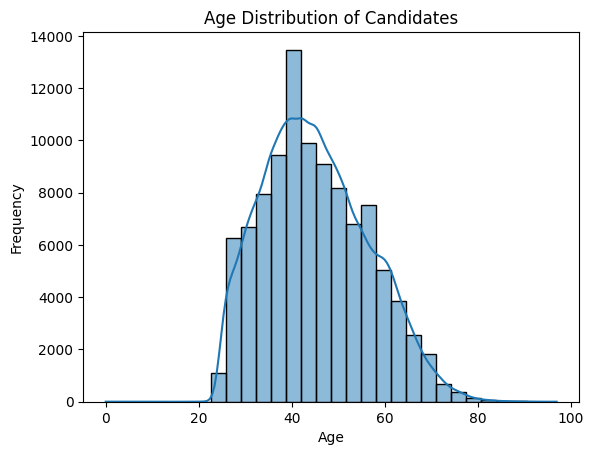

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(data['age'].dropna(), bins=30, kde=True)
plt.title("Age Distribution of Candidates")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()


In [175]:

group_median_age = data.groupby(['position', 'sex', 'party'])['age'].median()
def impute_age(row):
    if pd.notna(row['age']):
        return row['age']
    return group_median_age.get((row['position'], row['sex'], row['party']), data['age'].median())
data['age'] = data.apply(impute_age, axis=1)
print("Remaining missing in 'age':", data['age'].isna().sum())


Remaining missing in 'age': 8539


In [176]:
broader_group_median = data.groupby(['position', 'sex'])['age'].median()
def second_pass_impute(row):
    if pd.notna(row['age']):
        return row['age']
    return broader_group_median.get((row['position'], row['sex']), data['age'].median())

data['age'] = data.apply(second_pass_impute, axis=1)


In [177]:
print("Remaining missing in 'age':", data['age'].isna().sum())

Remaining missing in 'age': 6476


In [178]:
data['age'] = data['age'].fillna(data['age'].median())


In [179]:
print("Remaining missing in 'age':", data['age'].isna().sum())

Remaining missing in 'age': 0


In [180]:
data.isnull().sum()

id                         0
year                       0
month                      0
state_name                 0
state_code                 0
assembly_no                0
ac_name                    0
ac_type                    0
candidate_name             0
sex                        0
age                        0
candidate_type             0
party                      0
position                   0
ac_total_candidates        0
total_electors           254
total_votes                0
total_valid_votes          0
vote_share_percentage      0
margin                     0
margin_percentage          0
turnout_percentage         0
poll_no                    0
delimit_id                 0
dtype: int64

In [181]:
group_mean_electors = data.groupby(['state_name', 'year', 'ac_name'])['total_electors'].transform('mean')
data['total_electors'] = data['total_electors'].fillna(group_mean_electors)
print("Remaining missing in 'total_electors':", data['total_electors'].isna().sum())


Remaining missing in 'total_electors': 249


In [182]:
data['total_electors'] = data['total_electors'].fillna(data['total_electors'].mean())


In [183]:
print("Remaining missing in 'total_electors':", data['total_electors'].isna().sum())


Remaining missing in 'total_electors': 0


In [184]:
data.isnull().sum()

id                       0
year                     0
month                    0
state_name               0
state_code               0
assembly_no              0
ac_name                  0
ac_type                  0
candidate_name           0
sex                      0
age                      0
candidate_type           0
party                    0
position                 0
ac_total_candidates      0
total_electors           0
total_votes              0
total_valid_votes        0
vote_share_percentage    0
margin                   0
margin_percentage        0
turnout_percentage       0
poll_no                  0
delimit_id               0
dtype: int64

In [185]:
print("Dataset shape:", data.shape)
print("\nColumn types:\n", data.dtypes)
print("\nSummary Stats:\n", data.describe())


Dataset shape: (122559, 24)

Column types:
 id                         int64
year                       int64
month                      int64
state_name                object
state_code                 int64
assembly_no              float64
ac_name                   object
ac_type                   object
candidate_name            object
sex                       object
age                      float64
candidate_type            object
party                     object
position                 float64
ac_total_candidates      float64
total_electors           float64
total_votes              float64
total_valid_votes        float64
vote_share_percentage    float64
margin                   float64
margin_percentage        float64
turnout_percentage       float64
poll_no                  float64
delimit_id               float64
dtype: object

Summary Stats:
                   id           year          month     state_code  \
count  122559.000000  122559.000000  122559.000000  122559.00000

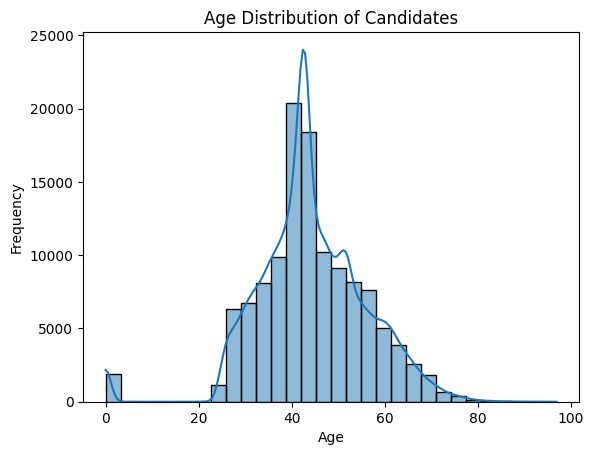

In [186]:
sns.histplot(data['age'], bins=30, kde=True)
plt.title("Age Distribution of Candidates")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

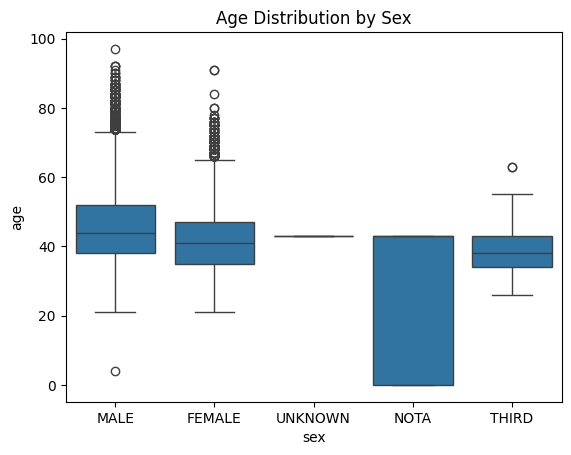

In [187]:
sns.boxplot(x='sex', y='age', data=data)
plt.title("Age Distribution by Sex")
plt.show()

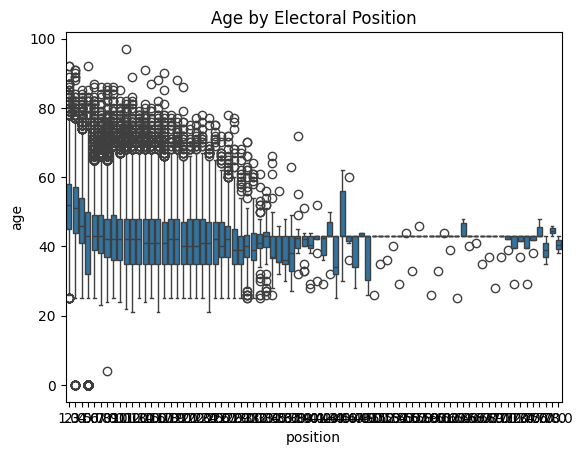

In [188]:
sns.boxplot(x='position', y='age', data=data)
plt.title("Age by Electoral Position")
plt.show()

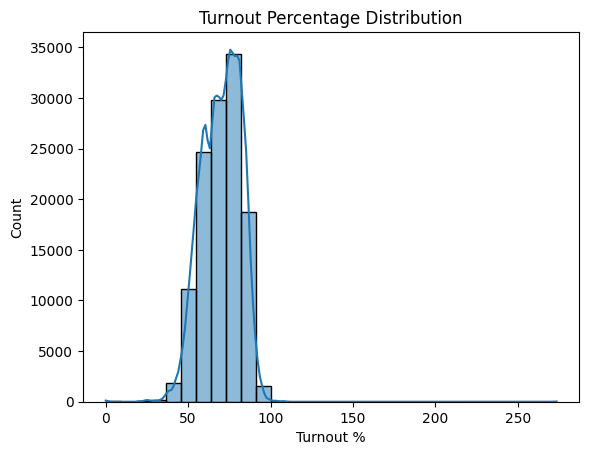

In [189]:
sns.histplot(data['turnout_percentage'], bins=30, kde=True)
plt.title("Turnout Percentage Distribution")
plt.xlabel("Turnout %")
plt.show()

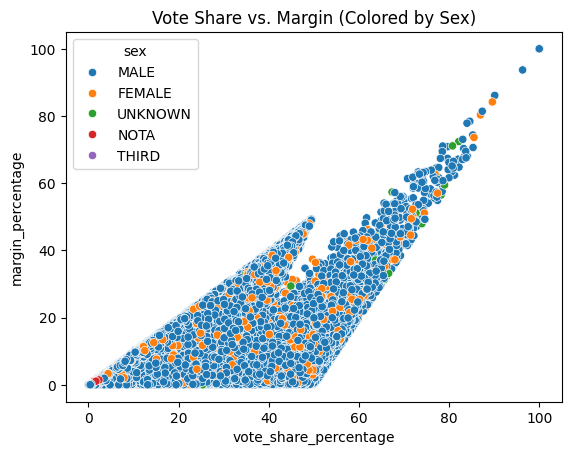

In [190]:
sns.scatterplot(x='vote_share_percentage', y='margin_percentage', hue='sex', data=data)
plt.title("Vote Share vs. Margin (Colored by Sex)")
plt.show()


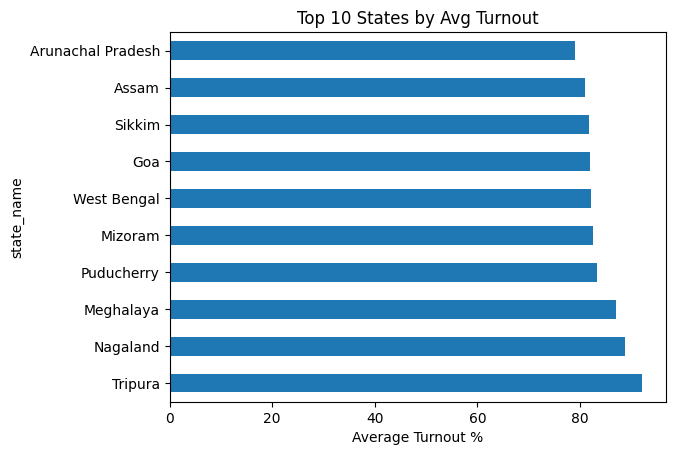

In [191]:
turnout_by_state = data.groupby('state_name')['turnout_percentage'].mean().sort_values(ascending=False).head(10)
turnout_by_state.plot(kind='barh', title="Top 10 States by Avg Turnout")
plt.xlabel("Average Turnout %")
plt.show()

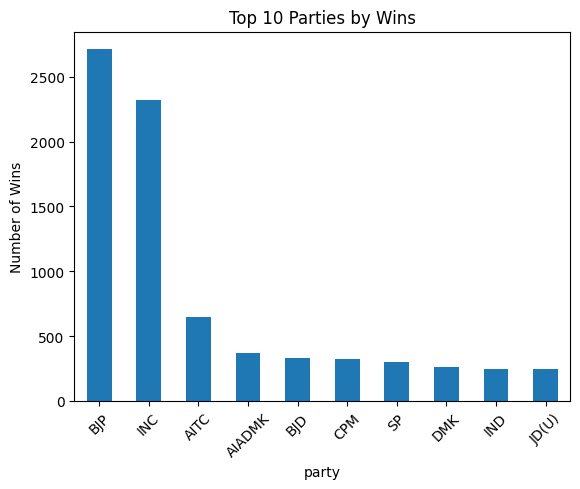

In [192]:
party_wins = data[data['position'] == 1]['party'].value_counts().head(10)
party_wins.plot(kind='bar', title='Top 10 Parties by Wins')
plt.ylabel("Number of Wins")
plt.xticks(rotation=45)
plt.show()

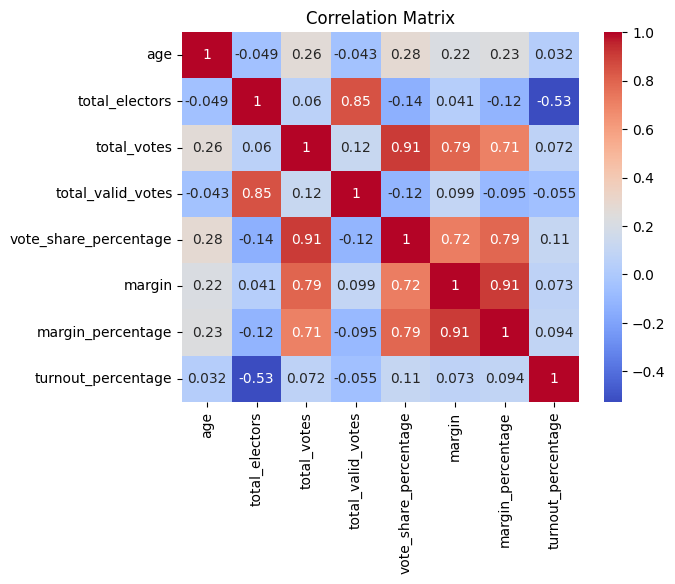

In [193]:
numeric_cols = ['age', 'total_electors', 'total_votes', 'total_valid_votes',
                'vote_share_percentage', 'margin', 'margin_percentage', 'turnout_percentage']
sns.heatmap(data[numeric_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [194]:
data['is_winner'] = (data['position'] == 1).astype(int)
data['vote_margin_ratio'] = data['margin'] / (data['total_votes'] + 1)  # +1 to avoid division by zero


In [195]:
bins = [0, 30, 40, 50, 60, 100]
labels = ['<30', '30–40', '40–50', '50–60', '60+']
data['age_group'] = pd.cut(data['age'], bins=bins, labels=labels)


In [196]:
data['high_turnout'] = (data['turnout_percentage'] > 70).astype(int)


In [197]:
data['effective_vote_share'] = (data['vote_share_percentage'] * data['turnout_percentage']) / 100


In [198]:
data['is_NOTA'] = (data['candidate_name'].str.upper() == 'NOTA').astype(int)


In [199]:
party_strength = (
    data[data['is_winner'] == 1]
    .groupby(['state_name', 'year', 'party'])
    .size()
    .reset_index(name='party_wins')
)

data = data.merge(party_strength, on=['state_name', 'year', 'party'], how='left')
data['party_wins'] = data['party_wins'].fillna(0)


In [200]:
print(data[['is_winner', 'vote_margin_ratio', 'age_group', 'high_turnout', 'effective_vote_share', 'is_NOTA', 'party_wins']].head())


   is_winner  vote_margin_ratio age_group  high_turnout  effective_vote_share  \
0          1           0.071717     50–60             0             31.931958   
1          0           0.928611     40–50             0             29.643249   
2          0           0.355063     40–50             0              2.116884   
3          0           0.188260     30–40             0              1.367727   
4          0           0.023962     30–40             0              1.106553   

   is_NOTA  party_wins  
0        0        92.0  
1        0       157.0  
2        0        18.0  
3        0         1.0  
4        0         0.0  


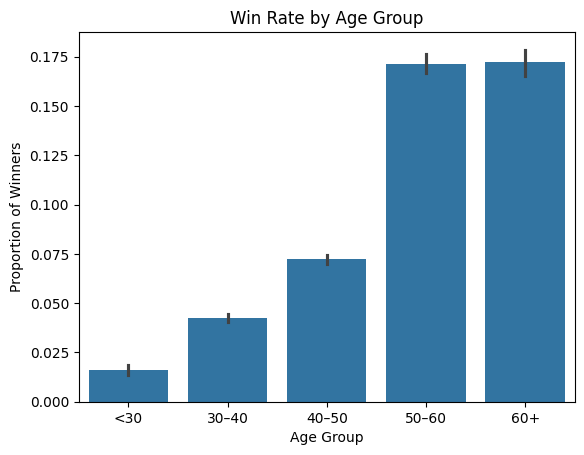

In [201]:
sns.barplot(data=data, x='age_group', y='is_winner')
plt.title("Win Rate by Age Group")
plt.ylabel("Proportion of Winners")
plt.xlabel("Age Group")
plt.show()


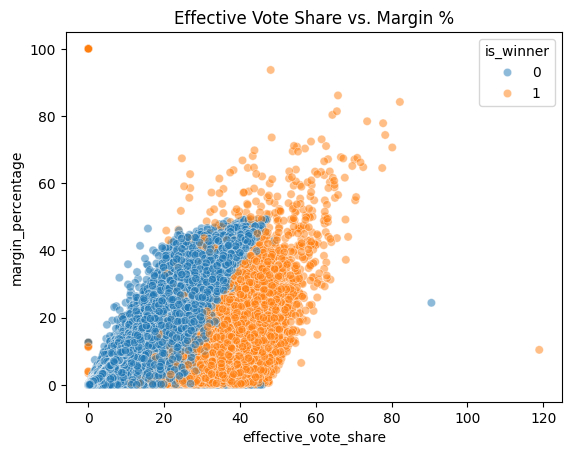

In [202]:
sns.scatterplot(data=data, x='effective_vote_share', y='margin_percentage', hue='is_winner', alpha=0.5)
plt.title("Effective Vote Share vs. Margin %")
plt.show()


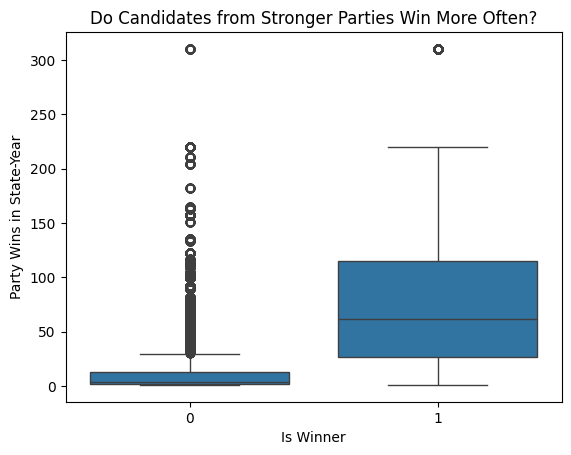

In [203]:
sns.boxplot(data=data[data['party_wins'] > 0], x='is_winner', y='party_wins')
plt.title("Do Candidates from Stronger Parties Win More Often?")
plt.xlabel("Is Winner")
plt.ylabel("Party Wins in State-Year")
plt.show()


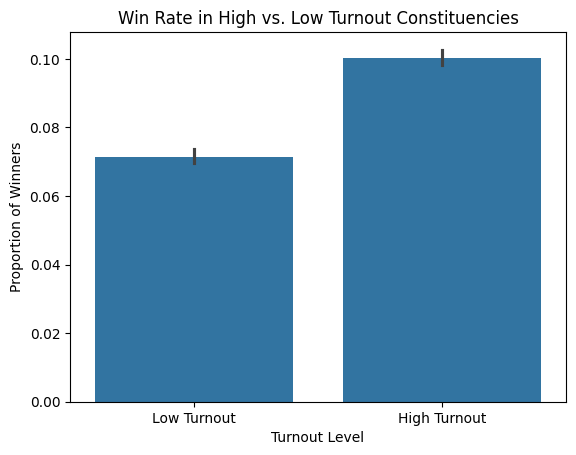

In [204]:
sns.barplot(data=data, x='high_turnout', y='is_winner')
plt.title("Win Rate in High vs. Low Turnout Constituencies")
plt.xticks([0,1], ['Low Turnout', 'High Turnout'])
plt.ylabel("Proportion of Winners")
plt.xlabel("Turnout Level")
plt.show()


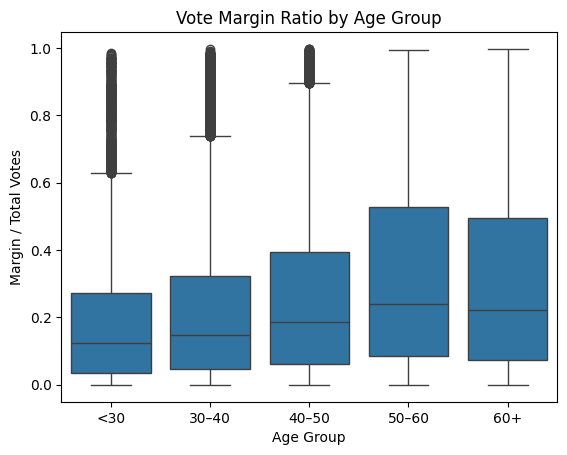

In [205]:
sns.boxplot(data=data, x='age_group', y='vote_margin_ratio')
plt.title("Vote Margin Ratio by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Margin / Total Votes")
plt.show()


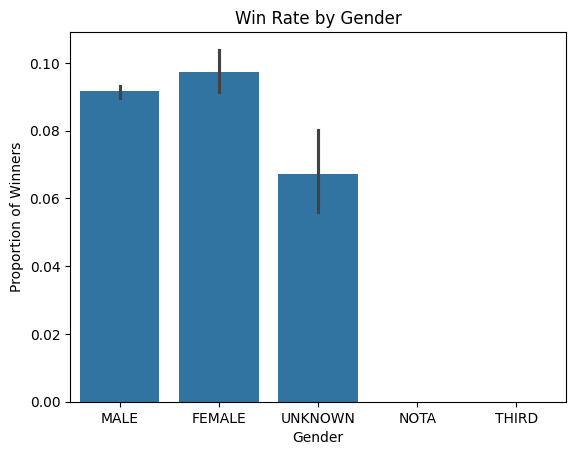

In [206]:
sns.barplot(data=data, x='sex', y='is_winner')
plt.title("Win Rate by Gender")
plt.xlabel("Gender")
plt.ylabel("Proportion of Winners")
plt.show()


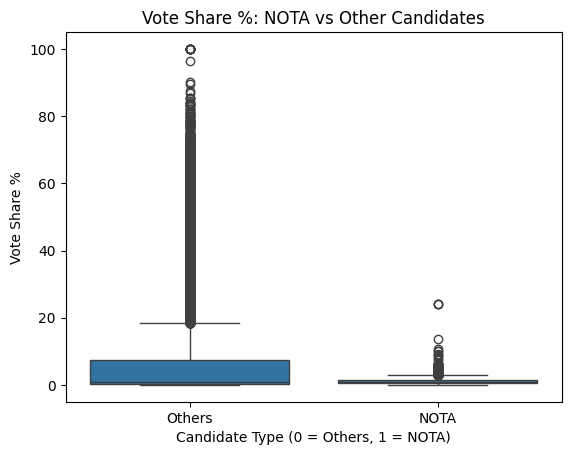

In [207]:
sns.boxplot(data=data, x='is_NOTA', y='vote_share_percentage')
plt.title("Vote Share %: NOTA vs Other Candidates")
plt.xlabel("Candidate Type (0 = Others, 1 = NOTA)")
plt.ylabel("Vote Share %")
plt.xticks([0, 1], ['Others', 'NOTA'])
plt.show()


In [208]:
mask = (data['total_votes'] > 0) & (data['total_valid_votes'] <= data['total_votes'])
print("Eligible rows for vote share calculation:", mask.sum())


Eligible rows for vote share calculation: 11


In [209]:
data.drop(columns=['vote_share_percentage'], inplace=True)


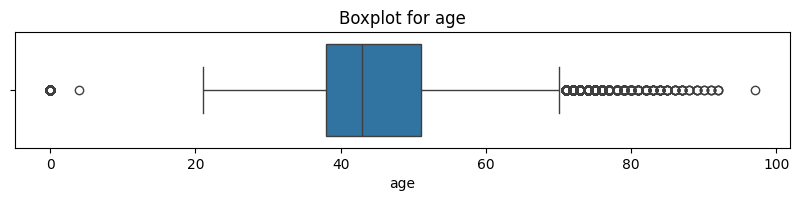

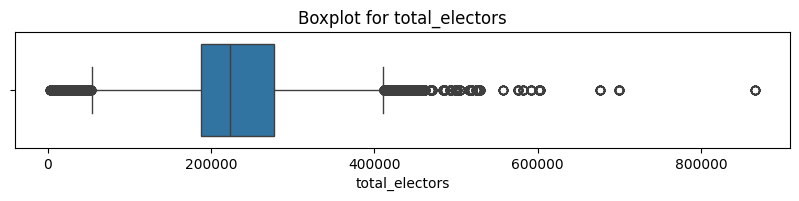

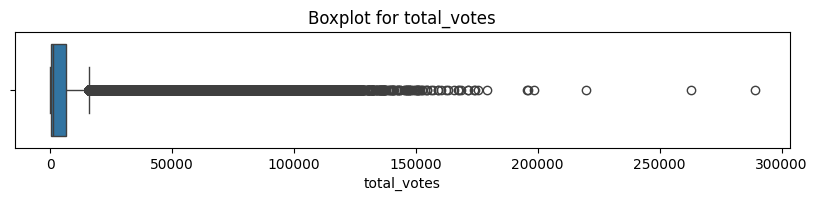

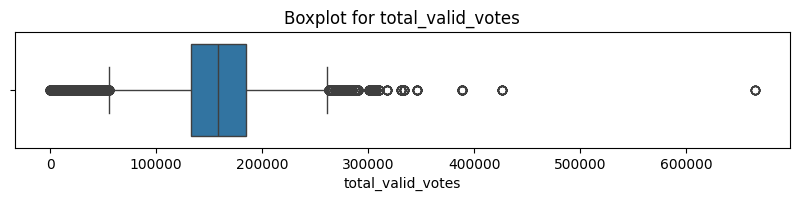

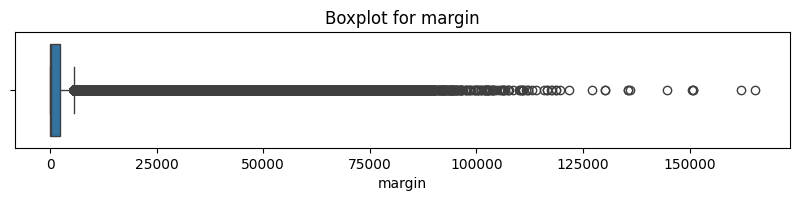

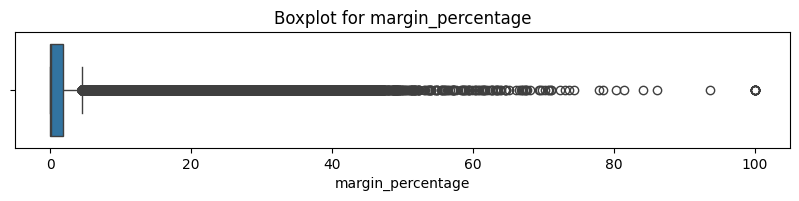

In [210]:
import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = ['age', 'total_electors', 'total_votes', 'total_valid_votes', 
                'margin', 'margin_percentage']

for col in numeric_cols:
    plt.figure(figsize=(10, 1.5))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot for {col}')
    plt.show()


In [211]:
data.rename(columns={'total_valid_votes': 'constituency_valid_votes'}, inplace=True)


In [212]:
winners = data[data['is_winner'] == 1]
losers = data[data['is_winner'] == 0]
def remove_outliers(df, cols):
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 3.0 * IQR
        upper = Q3 + 3.0 * IQR
        df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

cols_to_clean = ['age', 'turnout_percentage', 'margin', 'margin_percentage', 'effective_vote_share']
losers_cleaned = remove_outliers(losers, cols_to_clean)
data = pd.concat([winners, losers_cleaned], ignore_index=True)
print(data['is_winner'].value_counts())
print(" Final data shape:", data.shape)


is_winner
0    83957
1    10623
Name: count, dtype: int64
 Final data shape: (94580, 30)


In [213]:
print("Current columns in your dataset:")
print(data.columns.tolist())


Current columns in your dataset:
['id', 'year', 'month', 'state_name', 'state_code', 'assembly_no', 'ac_name', 'ac_type', 'candidate_name', 'sex', 'age', 'candidate_type', 'party', 'position', 'ac_total_candidates', 'total_electors', 'total_votes', 'constituency_valid_votes', 'margin', 'margin_percentage', 'turnout_percentage', 'poll_no', 'delimit_id', 'is_winner', 'vote_margin_ratio', 'age_group', 'high_turnout', 'effective_vote_share', 'is_NOTA', 'party_wins']


In [214]:
print(data['is_winner'].value_counts())


is_winner
0    83957
1    10623
Name: count, dtype: int64


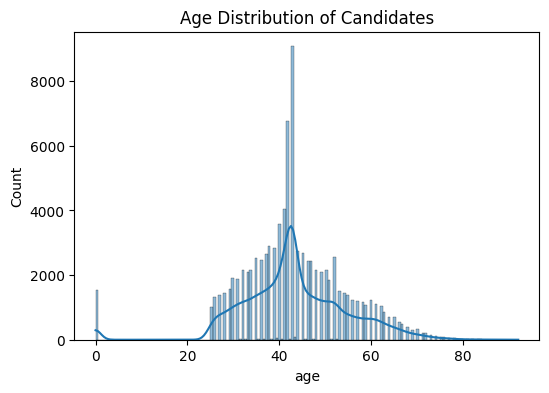

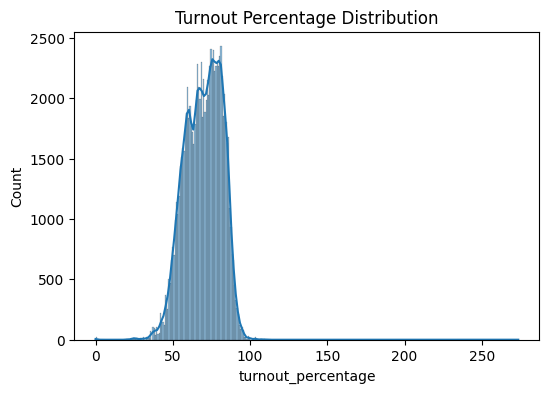

In [215]:
import seaborn as sns


# Basic distributions
plt.figure(figsize=(6,4))
sns.histplot(data['age'], kde=True)
plt.title("Age Distribution of Candidates")
plt.show()
plt.figure(figsize=(6,4))
sns.histplot(data['turnout_percentage'], kde=True)
plt.title("Turnout Percentage Distribution")
plt.show()

 


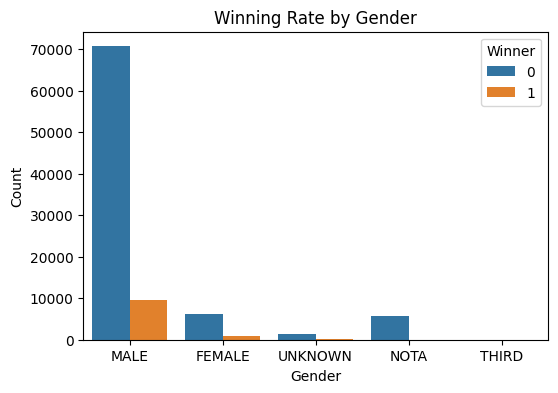

In [216]:
plt.figure(figsize=(6,4))
sns.countplot(x='sex', hue='is_winner', data=data)
plt.title("Winning Rate by Gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.legend(title='Winner')
plt.show()

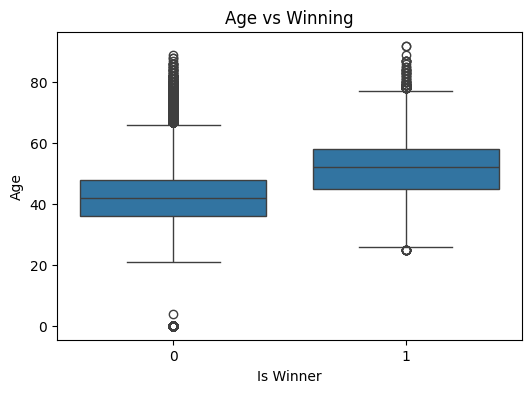

In [217]:
# Age vs Win (boxplot)
plt.figure(figsize=(6,4))
sns.boxplot(x='is_winner', y='age', data=data)
plt.title("Age vs Winning")
plt.xlabel("Is Winner")
plt.ylabel("Age")
plt.show()


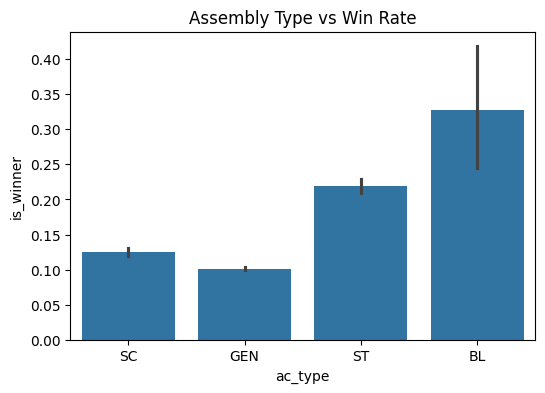

In [218]:
# Assembly type vs Win
plt.figure(figsize=(6,4))
sns.barplot(x='ac_type', y='is_winner', data=data)
plt.title("Assembly Type vs Win Rate")
plt.show()

In [219]:
from sklearn.preprocessing import LabelEncoder
features = data[['age', 'sex', 'ac_type', 'turnout_percentage', 
                 'candidate_type', 'party']]
target = data['is_winner']
cat_cols = ['sex', 'ac_type', 'candidate_type', 'party']
for col in cat_cols:
    features[col] = features[col].fillna('Unknown')
    features[col] = LabelEncoder().fit_transform(features[col].astype(str))
features = features.fillna(features.median(numeric_only=True))


C:\Users\SHRI\AppData\Local\Temp\ipykernel_10872\1457724979.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[col] = features[col].fillna('Unknown')
C:\Users\SHRI\AppData\Local\Temp\ipykernel_10872\1457724979.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[col] = LabelEncoder().fit_transform(features[col].astype(str))
C:\Users\SHRI\AppData\Local\Temp\ipykernel_10872\1457724979.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

📋 Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     16791
           1       0.80      0.70      0.75      2125

    accuracy                           0.95     18916
   macro avg       0.88      0.84      0.86     18916
weighted avg       0.94      0.95      0.95     18916

🔢 Confusion Matrix:
 [[16431   360]
 [  647  1478]]


In [220]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
X_train, X_test, y_train, y_test = train_test_split(
    features, target, stratify=target, test_size=0.2, random_state=42)
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     16791
           1       0.80      0.70      0.75      2125

    accuracy                           0.95     18916
   macro avg       0.88      0.84      0.86     18916
weighted avg       0.94      0.95      0.95     18916

Confusion Matrix:
 [[16431   360]
 [  647  1478]]


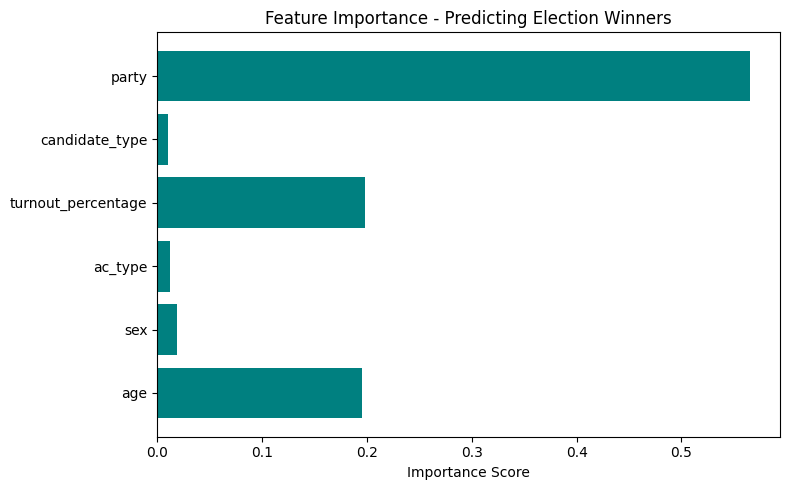

In [221]:
importances = model.feature_importances_
feature_names = features.columns
plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances, color='teal')
plt.title("Feature Importance - Predicting Election Winners")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [222]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier(scale_pos_weight=5, use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


C:\Users\SHRI\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:31:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96     16791
           1       0.66      0.87      0.75      2125

    accuracy                           0.94     18916
   macro avg       0.82      0.91      0.86     18916
weighted avg       0.95      0.94      0.94     18916

Confusion Matrix:
 [[15848   943]
 [  274  1851]]


In [223]:
from sklearn.neighbors import KNeighborsClassifier


knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

y_pred_knn = knn_model.predict(X_test)

print(" KNN Classification Report:\n", classification_report(y_test, y_pred_knn))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))


 KNN Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     16791
           1       0.79      0.71      0.75      2125

    accuracy                           0.95     18916
   macro avg       0.88      0.84      0.86     18916
weighted avg       0.94      0.95      0.95     18916

 Confusion Matrix:
 [[16390   401]
 [  612  1513]]


In [224]:
import lightgbm as lgb
lgb_model = lgb.LGBMClassifier(class_weight='balanced', random_state=42)
lgb_model.fit(X_train, y_train)

y_pred_lgb = lgb_model.predict(X_test)

print(" LightGBM Report:\n", classification_report(y_test, y_pred_lgb))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lgb))


[LightGBM] [Info] Number of positive: 8498, number of negative: 67166
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008070 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 604
[LightGBM] [Info] Number of data points in the train set: 75664, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
 LightGBM Report:
               precision    recall  f1-score   support

           0       0.99      0.93      0.96     16791
           1       0.64      0.91      0.75      2125

    accuracy                           0.93     18916
   macro avg       0.81      0.92      0.85     18916
weighted avg       0.95      0.93      0.94     18916

 Confusion Matrix:
 [[15682  1109]
 [  191  1934]]


In [225]:
pip install catboost


Note: you may need to restart the kernel to use updated packages.


In [226]:
from catboost import CatBoostClassifier

cat_model = CatBoostClassifier(verbose=0, random_state=42, class_weights=[1, 5])  # Class 1 is rare
cat_model.fit(X_train, y_train)

y_pred_cat = cat_model.predict(X_test)

print(" CatBoost Report:\n", classification_report(y_test, y_pred_cat))
print(" Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cat))


 CatBoost Report:
               precision    recall  f1-score   support

           0       0.99      0.95      0.97     16791
           1       0.71      0.90      0.80      2125

    accuracy                           0.95     18916
   macro avg       0.85      0.93      0.88     18916
weighted avg       0.96      0.95      0.95     18916

 Confusion Matrix:
 [[16013   778]
 [  207  1918]]


In [227]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)

print("Naive Bayes Report:\n", classification_report(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))


Naive Bayes Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.93     16791
           1       0.30      0.16      0.21      2125

    accuracy                           0.86     18916
   macro avg       0.60      0.56      0.57     18916
weighted avg       0.83      0.86      0.84     18916

Confusion Matrix:
 [[16013   778]
 [ 1792   333]]


In [228]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
models = {
    'Random Forest': model,
    'XGBoost': xgb_model,
    'KNN': knn_model,
    'LightGBM': lgb_model,
    'CatBoost': cat_model,
    'Naive Bayes': nb_model
}
results = []

for name, m in models.items():
    y_pred = m.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': round(acc, 4),
        'Precision (Winner)': round(prec, 4),
        'Recall (Winner)': round(rec, 4),
        'F1 Score (Winner)': round(f1, 4)
    })
results_df = pd.DataFrame(results).sort_values(by='F1 Score (Winner)', ascending=False).reset_index(drop=True)
print(" Model Comparison Table:")
display(results_df)


 Model Comparison Table:


,Model,Accuracy,Precision (Winner),Recall (Winner),F1 Score (Winner)
0,CatBoost,0.9479,0.7114,0.9026,0.7957
1,XGBoost,0.9357,0.6625,0.8711,0.7526
2,KNN,0.9464,0.7905,0.7120,0.7492
3,LightGBM,0.9313,0.6356,0.9101,0.7485
4,Random Forest,0.9468,0.8041,0.6955,0.7459
5,Naive Bayes,0.8641,0.2997,0.1567,0.2058


<Axes: xlabel='is_winner', ylabel='turnout_percentage'>

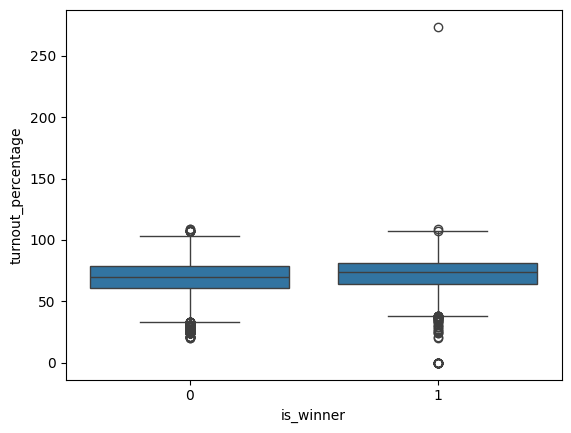

In [229]:
sns.boxplot(x='is_winner', y='turnout_percentage', data=data)


<Axes: xlabel='is_winner', ylabel='age'>

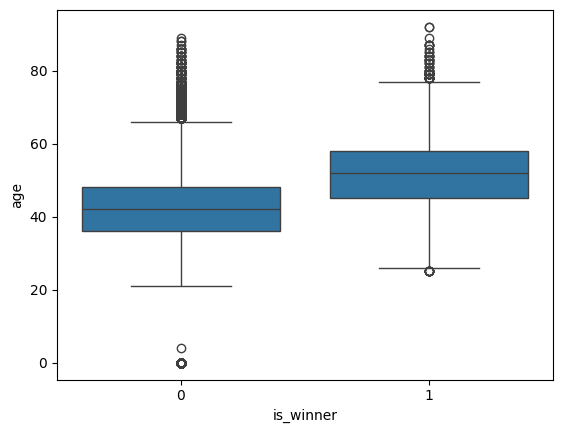

In [230]:
sns.boxplot(x='is_winner', y='age', data=data)


<Axes: xlabel='candidate_type', ylabel='count'>

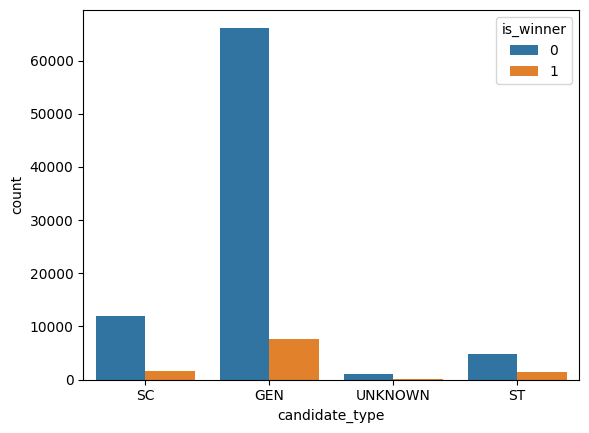

In [231]:
sns.countplot(x='candidate_type', hue='is_winner', data=data)


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'INC'),
  Text(1, 0, 'BJP'),
  Text(2, 0, 'IND'),
  Text(3, 0, 'JD(U)'),
  Text(4, 0, 'AITC'),
  Text(5, 0, 'NCP'),
  Text(6, 0, 'BSP'),
  Text(7, 0, 'AAAP'),
  Text(8, 0, 'SP'),
  Text(9, 0, 'NOTA')])

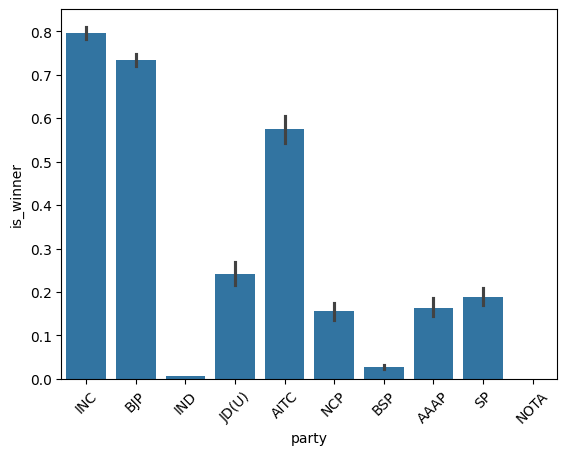

In [232]:
top_parties = data['party'].value_counts().head(10).index
sns.barplot(data=data[data['party'].isin(top_parties)], x='party', y='is_winner')
plt.xticks(rotation=45)


<Axes: xlabel='ac_type', ylabel='count'>

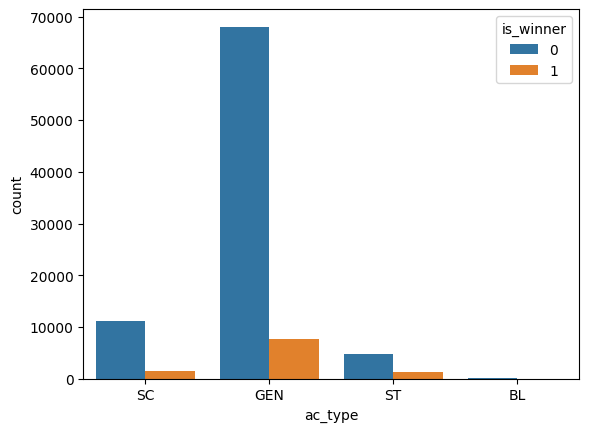

In [233]:
sns.countplot(x='ac_type', hue='is_winner', data=data)


<Axes: title={'center': 'Top 15 Parties by Winning Rate'}, ylabel='party'>

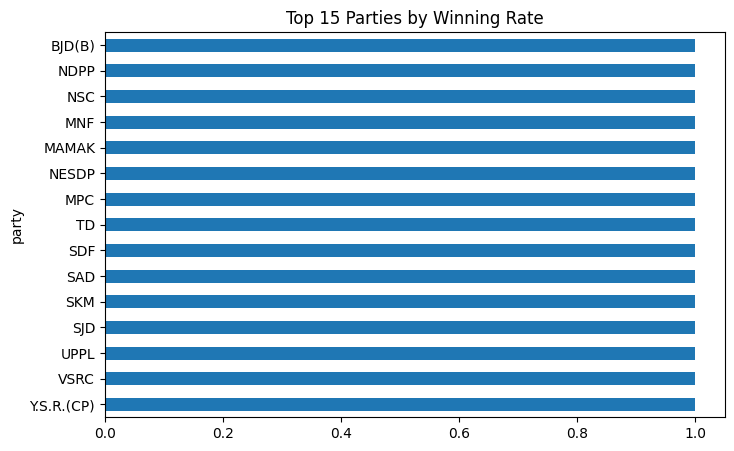

In [234]:
party_win_rate = data.groupby('party')['is_winner'].mean().sort_values(ascending=False).head(15)
party_win_rate.plot(kind='barh', title='Top 15 Parties by Winning Rate', figsize=(8,5))


Text(0.5, 1.0, 'Distribution of Winning Margin %')

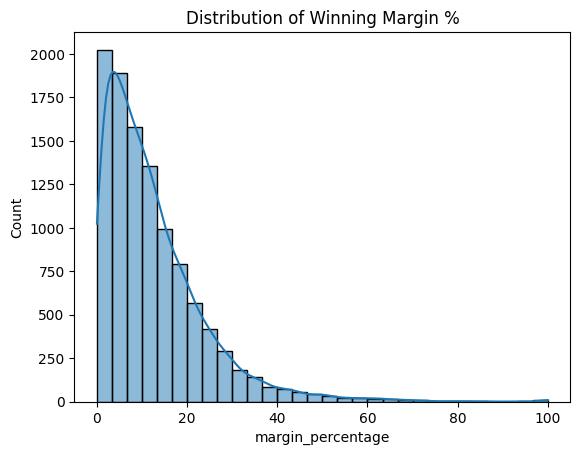

In [235]:
sns.histplot(data[data['is_winner']==1]['margin_percentage'], bins=30, kde=True)
plt.title("Distribution of Winning Margin %")


In [236]:
importances = model.feature_importances_
pd.Series(importances, index=features.columns).sort_values(ascending=False).head(5)


party                 0.565666
turnout_percentage    0.197756
age                   0.195739
sex                   0.018833
ac_type               0.012058
dtype: float64

<Axes: xlabel='ac_type', ylabel='ac_total_candidates'>

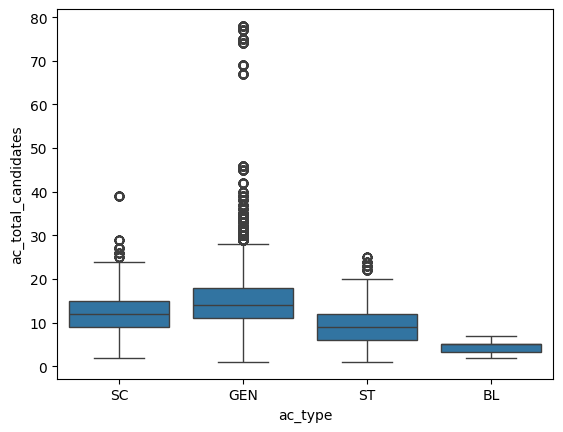

In [237]:
sns.boxplot(x='ac_type', y='ac_total_candidates', data=data)


C:\Users\SHRI\AppData\Local\Programs\Python\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


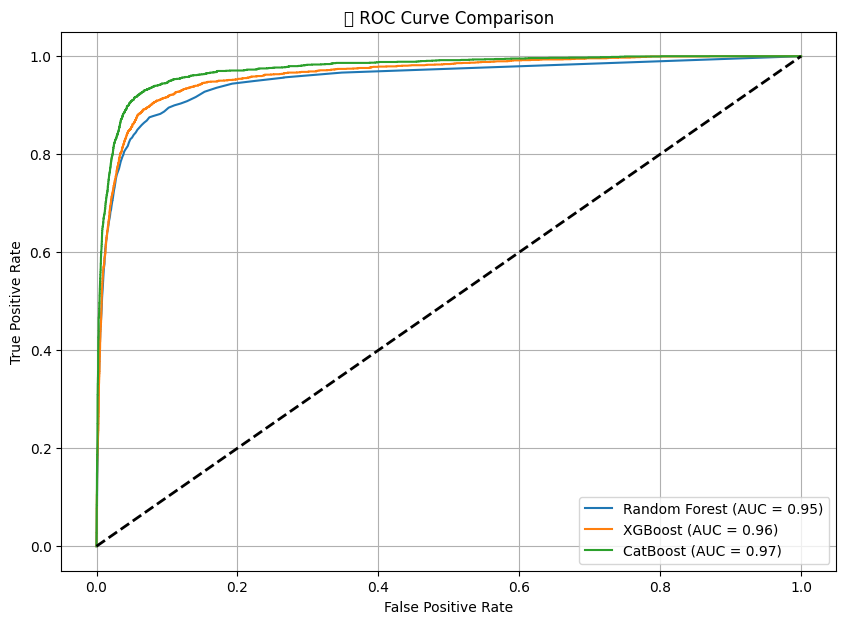

In [238]:
from sklearn.metrics import roc_curve, auc
models = {
    "Random Forest": model,
    "XGBoost": xgb_model,
    "CatBoost": cat_model
}

plt.figure(figsize=(10,7))

for name, m in models.items():
    y_probs = m.predict_proba(X_test)[:, 1]
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid()
plt.show()
